In [2]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import time
import json
import matplotlib.pyplot as plt

# Получение и подготовка данных из Transpose.io

## Выгрузка данных по токену PEPE

Выгрузка происходит через метод /sql REST API Transpose.io, который позволяет написать запрос с фильтрами и выводом необходимой информации  

In [3]:
url = 'https://api.transpose.io/sql'

sql_query = """
select t.symbol,
       p.price,
       tt.timestamp,
       tt."from_address",
       tt."to_address",
       tt.quantity / power(10, t.decimals) as quantity,
       tt.quantity / power(10, t.decimals) * p.price as total_price,
       tt.log_index
from ethereum.token_transfers tt
         join ethereum.tokens t on tt.contract_address = t.contract_address
         join ethereum.token_prices p on tt.timestamp = p.timestamp and t.symbol = p.token_symbol
where tt.timestamp > '2024-01-01 00:00:00'
and tt.contract_address = '0x6982508145454ce325ddbe47a25d4ec3d2311933'
  and tt.timestamp > '2024-01-01 00:00:00'
  and tt.category = 'send'
  and (tt.timestamp, tt.log_index) > ('{{timestamp}}', {{log_index}})
order by tt.timestamp, tt.log_index
limit 1000;
"""

API_KEY = '93gVmNCViWY9SukxHzcq2JwwvkPgmvDo'

headers = {
    'Content-Type': 'application/json',
    'X-API-KEY': API_KEY
}

# Время начала и окончания запрашиваемого интервала данных
from_timestamp = '2024-12-01 00:00:00'
to_timestamp = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
log_index = -1

df_raw = pd.DataFrame()
# Получаем данные в виде JSON и записываем в таблицу pandas
while True:
    response = requests.post(
        url,
        headers=headers,
        json={'sql': sql_query, 'parameters': {'timestamp': from_timestamp, 'log_index': log_index}},
    )
    results = response.json()['results']
    df_raw = pd.concat([df_raw,  pd.DataFrame(results)], ignore_index=True)
    print(('Recieved {} results where timestamp > {} and timestamp <= {}').format(len(results), from_timestamp, results[-1]['timestamp']))
    # Если доходим до последней страницы, заканчиваем запрос данных
    if results[-1]['timestamp'] >= to_timestamp:
        break
    from_timestamp = results[-1]['timestamp']
    log_index = results[-1]['log_index']
    time.sleep(2)

Recieved 1000 results where timestamp > 2024-12-01 00:00:00 and timestamp <= 2024-12-01T04:09:47Z
Recieved 1000 results where timestamp > 2024-12-01T04:09:47Z and timestamp <= 2024-12-01T09:20:11Z
Recieved 1000 results where timestamp > 2024-12-01T09:20:11Z and timestamp <= 2024-12-01T14:06:47Z
Recieved 1000 results where timestamp > 2024-12-01T14:06:47Z and timestamp <= 2024-12-01T16:01:47Z
Recieved 1000 results where timestamp > 2024-12-01T16:01:47Z and timestamp <= 2024-12-01T18:12:11Z
Recieved 1000 results where timestamp > 2024-12-01T18:12:11Z and timestamp <= 2024-12-01T21:20:11Z
Recieved 1000 results where timestamp > 2024-12-01T21:20:11Z and timestamp <= 2024-12-02T00:10:47Z
Recieved 1000 results where timestamp > 2024-12-02T00:10:47Z and timestamp <= 2024-12-02T02:51:35Z
Recieved 1000 results where timestamp > 2024-12-02T02:51:35Z and timestamp <= 2024-12-02T06:28:47Z
Recieved 1000 results where timestamp > 2024-12-02T06:28:47Z and timestamp <= 2024-12-02T13:07:35Z
Recieved 10

KeyError: 'results'

In [5]:
response.json()

{'status': 'error', 'message': 'Out of credits'}

К сожалению, во время решения закончились бесплатные запросы по ключу АПИ...
Однако, какие-то данные загрузились, в общем смысл остается таким же

Проверим верхнеуровнево типы данных, а также количество ненулевых значений

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159000 entries, 0 to 158999
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   symbol        159000 non-null  object 
 1   price         159000 non-null  float64
 2   timestamp     159000 non-null  object 
 3   from_address  159000 non-null  object 
 4   to_address    159000 non-null  object 
 5   quantity      159000 non-null  float64
 6   total_price   159000 non-null  float64
 7   log_index     159000 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 9.7+ MB


Для работы с данными необходимо сделать преобразование времени в формат datetime

In [7]:
df = df_raw.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159000 entries, 0 to 158999
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   symbol        159000 non-null  object             
 1   price         159000 non-null  float64            
 2   timestamp     159000 non-null  datetime64[ns, UTC]
 3   from_address  159000 non-null  object             
 4   to_address    159000 non-null  object             
 5   quantity      159000 non-null  float64            
 6   total_price   159000 non-null  float64            
 7   log_index     159000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(3)
memory usage: 9.7+ MB


## Расчет метрики Active addresses

Метрика представляет из себя количество уникальных активных адресов в период времени

In [8]:
active_adresses = df.groupby('timestamp')['from_address'].nunique()
active_adresses

,from_address
timestamp,
2024-12-01 00:00:47+00:00,4
2024-12-01 00:01:35+00:00,2
2024-12-01 00:03:11+00:00,1
2024-12-01 00:06:23+00:00,2
2024-12-01 00:07:23+00:00,2
...,...
2025-01-02 14:37:35+00:00,2
2025-01-02 14:38:47+00:00,2
2025-01-02 14:38:59+00:00,1


## Расчет метрики One to many transfers

Количество получателей в разрезе отправителей.

In [9]:
one_to_many_transfers = df.groupby('from_address')['to_address'].count()
one_to_many_transfers

,to_address
from_address,
0x00000000003b3cc22aF3aE1EAc0440BcEe416B40,1
0x00000000004E3D5628234F18b977041e5242651f,4
0x00000000009726632680FB29d3F7A9734E3010E2,75
0x00000000009E50a7dDb7a7B0e2ee6604fd120E49,52
0x0000000000bbF5c5Fd284e657F01Bd000933C96D,14
...,...
0xffa7ddB69aB6776d5030eA951006F02356559525,3
0xffc191ecDa40AC0A30cD910283741863240AbaB9,1
0xffdCD023a8F07B23a58d491c4500F532f4766F01,1


## Расчет метрики many_to_one_transfers

Количество отправителей в разрезе получателей.

In [10]:
many_to_one_transfers = df.groupby('to_address')['from_address'].count()
many_to_one_transfers

,from_address
to_address,
0x00000000003b3cc22aF3aE1EAc0440BcEe416B40,1
0x00000000004E3D5628234F18b977041e5242651f,2
0x00000000009726632680FB29d3F7A9734E3010E2,74
0x00000000009E50a7dDb7a7B0e2ee6604fd120E49,50
0x0000000000bbF5c5Fd284e657F01Bd000933C96D,14
...,...
0xffc6EE6619Db6d48100015F2b3C4DD2386567b96,1
0xffcE5691dBc78C19E20F67f007c80f5150880DCA,1
0xffdb0D439be79AB407329F23EB6D6a166b615135,1


## Количество и объем транзакций по бакетам

Бины по количеству

In [11]:
df['bins_quantity'] = pd.cut(df['quantity'], bins=[0, 100, 10000, 100000, np.inf], labels=['0-100', '100-10k', '10k-100k', '100k-inf'])
df

,symbol,price,timestamp,from_address,to_address,quantity,total_price,log_index,bins_quantity
0,PEPE,0.000020,2024-12-01 00:00:47+00:00,0xf17907CDf37dd43489A56cf31AE0F2b4C18652F2,0xa7Ca2C8673bcFA5a26d8ceeC2887f2CC2b0Db22A,4.653308e+07,937.187051,266,100k-inf
1,PEPE,0.000020,2024-12-01 00:00:47+00:00,0xa7Ca2C8673bcFA5a26d8ceeC2887f2CC2b0Db22A,0xA43fe16908251ee70EF74718545e4FE6C5cCEc9f,4.653308e+07,937.187051,271,100k-inf
2,PEPE,0.000020,2024-12-01 00:00:47+00:00,0xff8Ba4D1fC3762f6154cc942CCF30049A2A0cEC6,0x70bf6634eE8Cb27D04478f184b9b8BB13E5f4710,3.070848e+08,6184.760110,549,100k-inf
3,PEPE,0.000020,2024-12-01 00:00:47+00:00,0x70bf6634eE8Cb27D04478f184b9b8BB13E5f4710,0x7AfA9D836d2fCCf172b66622625e56404E465dBD,2.610221e+06,52.570461,552,100k-inf
4,PEPE,0.000020,2024-12-01 00:00:47+00:00,0x70bf6634eE8Cb27D04478f184b9b8BB13E5f4710,0x0977918a4F8B6421C8479C34974DF6D1c98b24c6,3.044746e+08,6132.189649,553,100k-inf
...,...,...,...,...,...,...,...,...,...
158995,PEPE,0.000610,2025-01-02 14:40:11+00:00,0xA43fe16908251ee70EF74718545e4FE6C5cCEc9f,0x1111111254EEB25477B68fb85Ed929f73A960582,2.407873e+05,146.919050,410,100k-inf
158996,PEPE,0.000021,2025-01-02 14:40:11+00:00,0x1111111254EEB25477B68fb85Ed929f73A960582,0x7964C349BE83bBFD4001B89b3AEA13d1e16D3fe4,2.407873e+05,4.956583,413,100k-inf
158997,PEPE,0.000610,2025-01-02 14:40:11+00:00,0x1111111254EEB25477B68fb85Ed929f73A960582,0x7964C349BE83bBFD4001B89b3AEA13d1e16D3fe4,2.407873e+05,146.919050,413,100k-inf
158998,PEPE,0.000021,2025-01-02 14:40:23+00:00,0x893c61594Ae334128D8545fC5F0c43c5937F5D50,0x11950d141EcB863F01007AdD7D1A342041227b58,3.200000e+07,658.513337,144,100k-inf


Бины по объему транзакций

In [12]:
df['bins_price'] = pd.cut(df['total_price'], bins=[0, 100, 10000, 100000, np.inf], labels=['0-100', '100-10k', '10k-100k', '100k-inf'])
df

,symbol,price,timestamp,from_address,to_address,quantity,total_price,log_index,bins_quantity,bins_price
0,PEPE,0.000020,2024-12-01 00:00:47+00:00,0xf17907CDf37dd43489A56cf31AE0F2b4C18652F2,0xa7Ca2C8673bcFA5a26d8ceeC2887f2CC2b0Db22A,4.653308e+07,937.187051,266,100k-inf,100-10k
1,PEPE,0.000020,2024-12-01 00:00:47+00:00,0xa7Ca2C8673bcFA5a26d8ceeC2887f2CC2b0Db22A,0xA43fe16908251ee70EF74718545e4FE6C5cCEc9f,4.653308e+07,937.187051,271,100k-inf,100-10k
2,PEPE,0.000020,2024-12-01 00:00:47+00:00,0xff8Ba4D1fC3762f6154cc942CCF30049A2A0cEC6,0x70bf6634eE8Cb27D04478f184b9b8BB13E5f4710,3.070848e+08,6184.760110,549,100k-inf,100-10k
3,PEPE,0.000020,2024-12-01 00:00:47+00:00,0x70bf6634eE8Cb27D04478f184b9b8BB13E5f4710,0x7AfA9D836d2fCCf172b66622625e56404E465dBD,2.610221e+06,52.570461,552,100k-inf,0-100
4,PEPE,0.000020,2024-12-01 00:00:47+00:00,0x70bf6634eE8Cb27D04478f184b9b8BB13E5f4710,0x0977918a4F8B6421C8479C34974DF6D1c98b24c6,3.044746e+08,6132.189649,553,100k-inf,100-10k
...,...,...,...,...,...,...,...,...,...,...
158995,PEPE,0.000610,2025-01-02 14:40:11+00:00,0xA43fe16908251ee70EF74718545e4FE6C5cCEc9f,0x1111111254EEB25477B68fb85Ed929f73A960582,2.407873e+05,146.919050,410,100k-inf,100-10k
158996,PEPE,0.000021,2025-01-02 14:40:11+00:00,0x1111111254EEB25477B68fb85Ed929f73A960582,0x7964C349BE83bBFD4001B89b3AEA13d1e16D3fe4,2.407873e+05,4.956583,413,100k-inf,0-100
158997,PEPE,0.000610,2025-01-02 14:40:11+00:00,0x1111111254EEB25477B68fb85Ed929f73A960582,0x7964C349BE83bBFD4001B89b3AEA13d1e16D3fe4,2.407873e+05,146.919050,413,100k-inf,100-10k
158998,PEPE,0.000021,2025-01-02 14:40:23+00:00,0x893c61594Ae334128D8545fC5F0c43c5937F5D50,0x11950d141EcB863F01007AdD7D1A342041227b58,3.200000e+07,658.513337,144,100k-inf,100-10k


## Анализ датасета

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159000 entries, 0 to 158999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   symbol         159000 non-null  object             
 1   price          159000 non-null  float64            
 2   timestamp      159000 non-null  datetime64[ns, UTC]
 3   from_address   159000 non-null  object             
 4   to_address     159000 non-null  object             
 5   quantity       159000 non-null  float64            
 6   total_price    159000 non-null  float64            
 7   log_index      159000 non-null  int64              
 8   bins_quantity  158940 non-null  category           
 9   bins_price     158940 non-null  category           
dtypes: category(2), datetime64[ns, UTC](1), float64(3), int64(1), object(3)
memory usage: 10.0+ MB


В датасете отсутствуют пропущенные данные. Отсутствие данных в сгенерированных колонках bins_quantity и bins_price имеют в колонках quantity значение 0, пооэтому они не попали в бины.

In [14]:
df[df.bins_price.isna()]

,symbol,price,timestamp,from_address,to_address,quantity,total_price,log_index,bins_quantity,bins_price
7551,PEPE,2.258942e-05,2024-12-02 01:34:47+00:00,0x70bf6634eE8Cb27D04478f184b9b8BB13E5f4710,0xD683B81c2608980DB90a6fD730153e04629ff1A3,0.0,0.0,128,NaN,NaN
27346,PEPE,2.145206e-05,2024-12-05 23:31:35+00:00,0x45fE0C5309189c57393bC554CA95A7611BD0Adbc,0x7397933586718941F1c943dAEDF3C6CE50Dac264,0.0,0.0,216,NaN,NaN
36937,PEPE,2.534317e-05,2024-12-07 19:38:35+00:00,0x6C42e3fE57dE9EAF0A4aD65b303a63071F16668A,0x05D2B2Bb9e989301ca1781E2c76C527E98F1d9c7,0.0,0.0,275,NaN,NaN
36938,PEPE,2.534317e-05,2024-12-07 19:38:35+00:00,0x0891f12265dD985048eD6749978908a72859bC4a,0x61b79d33A02b1c3757e8cDBc28F0e02Abd510cA9,0.0,0.0,277,NaN,NaN
38629,PEPE,2.586056e-05,2024-12-07 20:23:47+00:00,0x09Beeedf51AA45718F46837C94712d89B157a9D3,0xdc05090A39650026E6AFe89b2e795fd57a3cfEC7,0.0,0.0,142,NaN,NaN
40666,PEPE,2.576094e-05,2024-12-07 22:47:35+00:00,0x064ECDFa19399a7D7e5CbC0506e32ce90f720758,0x5fbFA99B8240eF711D5fDDbaa4a6a09ADFc9b58C,0.0,0.0,422,NaN,NaN
41268,PEPE,2.538060e-05,2024-12-07 23:31:47+00:00,0xa1ba4e08Fa684d10804F8Eab32cfc26Cb04867bd,0xf918f8796fFDFbB9163c97148134ca700E4404A3,0.0,0.0,161,NaN,NaN
44248,PEPE,2.583306e-05,2024-12-08 04:29:23+00:00,0x44B1FFEdF2A3ce178DcD6db20Ac9363427113Bf2,0x87B97AD47B8872F5cfbACFa6fc284541356f846B,0.0,0.0,72,NaN,NaN
45745,PEPE,4.219082e-10,2024-12-08 08:06:35+00:00,0x7b6f1BAFE42128735025B64D39f15750c8A2ebAf,0x8173bbB226646233428F1b7Dd7007B3859Bd69Bd,0.0,0.0,424,NaN,NaN
49389,PEPE,5.156708e-10,2024-12-08 17:41:47+00:00,0xbF145806d29c8Aa0358E0ceC98D4B3793d5BB7c6,0x1604c200b2f6a392Daf8D9C46442FfC963757716,0.0,0.0,211,NaN,NaN


Необходимо сменить нижнюю границу первого бина

In [15]:
df['bins_price'] = pd.cut(df['total_price'], bins=[-1, 100, 10000, 100000, np.inf], labels=['0-100', '100-10k', '10k-100k', '100k-inf'])
df['bins_quantity'] = pd.cut(df['total_price'], bins=[-1, 100, 10000, 100000, np.inf], labels=['0-100', '100-10k', '10k-100k', '100k-inf'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159000 entries, 0 to 158999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   symbol         159000 non-null  object             
 1   price          159000 non-null  float64            
 2   timestamp      159000 non-null  datetime64[ns, UTC]
 3   from_address   159000 non-null  object             
 4   to_address     159000 non-null  object             
 5   quantity       159000 non-null  float64            
 6   total_price    159000 non-null  float64            
 7   log_index      159000 non-null  int64              
 8   bins_quantity  159000 non-null  category           
 9   bins_price     159000 non-null  category           
dtypes: category(2), datetime64[ns, UTC](1), float64(3), int64(1), object(3)
memory usage: 10.0+ MB


## Анализ выбросов

Проверка выбросов основана на z-score, которая показывает, насколько отклоняется значение от среднего в стандартных отклонениях. Если значение отклоняется более чем на 3 ст. откл., то оно выбросное

In [16]:
from scipy.stats import zscore
df['zscores'] = zscore(df['total_price'].values)
df[df.zscores < 3]

,symbol,price,timestamp,from_address,to_address,quantity,total_price,log_index,bins_quantity,bins_price,zscores
0,PEPE,0.000020,2024-12-01 00:00:47+00:00,0xf17907CDf37dd43489A56cf31AE0F2b4C18652F2,0xa7Ca2C8673bcFA5a26d8ceeC2887f2CC2b0Db22A,4.653308e+07,937.187051,266,100-10k,100-10k,-0.004146
1,PEPE,0.000020,2024-12-01 00:00:47+00:00,0xa7Ca2C8673bcFA5a26d8ceeC2887f2CC2b0Db22A,0xA43fe16908251ee70EF74718545e4FE6C5cCEc9f,4.653308e+07,937.187051,271,100-10k,100-10k,-0.004146
2,PEPE,0.000020,2024-12-01 00:00:47+00:00,0xff8Ba4D1fC3762f6154cc942CCF30049A2A0cEC6,0x70bf6634eE8Cb27D04478f184b9b8BB13E5f4710,3.070848e+08,6184.760110,549,100-10k,100-10k,-0.004146
3,PEPE,0.000020,2024-12-01 00:00:47+00:00,0x70bf6634eE8Cb27D04478f184b9b8BB13E5f4710,0x7AfA9D836d2fCCf172b66622625e56404E465dBD,2.610221e+06,52.570461,552,0-100,0-100,-0.004146
4,PEPE,0.000020,2024-12-01 00:00:47+00:00,0x70bf6634eE8Cb27D04478f184b9b8BB13E5f4710,0x0977918a4F8B6421C8479C34974DF6D1c98b24c6,3.044746e+08,6132.189649,553,100-10k,100-10k,-0.004146
...,...,...,...,...,...,...,...,...,...,...,...
158995,PEPE,0.000610,2025-01-02 14:40:11+00:00,0xA43fe16908251ee70EF74718545e4FE6C5cCEc9f,0x1111111254EEB25477B68fb85Ed929f73A960582,2.407873e+05,146.919050,410,100-10k,100-10k,-0.004146
158996,PEPE,0.000021,2025-01-02 14:40:11+00:00,0x1111111254EEB25477B68fb85Ed929f73A960582,0x7964C349BE83bBFD4001B89b3AEA13d1e16D3fe4,2.407873e+05,4.956583,413,0-100,0-100,-0.004146
158997,PEPE,0.000610,2025-01-02 14:40:11+00:00,0x1111111254EEB25477B68fb85Ed929f73A960582,0x7964C349BE83bBFD4001B89b3AEA13d1e16D3fe4,2.407873e+05,146.919050,413,100-10k,100-10k,-0.004146
158998,PEPE,0.000021,2025-01-02 14:40:23+00:00,0x893c61594Ae334128D8545fC5F0c43c5937F5D50,0x11950d141EcB863F01007AdD7D1A342041227b58,3.200000e+07,658.513337,144,100-10k,100-10k,-0.004146


In [17]:
df[df.zscores >= 3]

,symbol,price,timestamp,from_address,to_address,quantity,total_price,log_index,bins_quantity,bins_price,zscores
7767,PEPE,3.456284e+11,2024-12-02 02:17:35+00:00,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0x11950d141EcB863F01007AdD7D1A342041227b58,1.642608e+09,5.677320e+20,1,100k-inf,100k-inf,274.665606
7768,PEPE,3.456284e+11,2024-12-02 02:17:35+00:00,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0xA43fe16908251ee70EF74718545e4FE6C5cCEc9f,1.571378e+09,5.431128e+20,3,100k-inf,100k-inf,262.754785
7769,PEPE,3.456284e+11,2024-12-02 02:17:35+00:00,0xA69babEF1cA67A37Ffaf7a485DfFF3382056e78C,0xA43fe16908251ee70EF74718545e4FE6C5cCEc9f,7.205073e+08,2.490278e+20,150,100k-inf,100k-inf,120.475950


<Axes: xlabel='log_index', ylabel='total_price'>

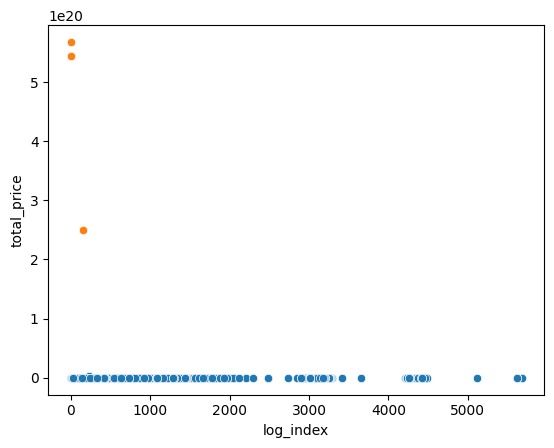

In [18]:
import seaborn as sb

sb.scatterplot(data = df[df.zscores < 3], x='log_index', y='total_price')
sb.scatterplot(data = df[df.zscores >= 3], x='log_index', y='total_price')

Визуализация показывает, что z-score позволяет отлично выявить отклонения в данных

## Генерация фичей

Среднее количество транзакций в день, дневной прирост активных адресов, сумма объема транзакций по дням

In [19]:
df_new_features = df.groupby('timestamp').agg(
        transactions_count=('symbol', 'count'),
        active_addresses=('from_address', pd.Series.nunique),
        total_volume=('quantity', 'sum')
    ).reset_index()
df_new_features['adresses_growth'] = df_new_features['active_addresses'].diff().fillna(0)
df_new_features

,timestamp,transactions_count,active_addresses,total_volume,adresses_growth
0,2024-12-01 00:00:47+00:00,5,4,7.072358e+08,0.0
1,2024-12-01 00:01:35+00:00,2,2,1.083151e+07,-2.0
2,2024-12-01 00:03:11+00:00,1,1,5.012987e+07,-1.0
3,2024-12-01 00:06:23+00:00,2,2,9.866798e+06,1.0
4,2024-12-01 00:07:23+00:00,2,2,1.828125e+07,0.0
...,...,...,...,...,...
40993,2025-01-02 14:37:35+00:00,2,2,7.107346e+08,0.0
40994,2025-01-02 14:38:47+00:00,2,2,1.134226e+09,0.0
40995,2025-01-02 14:38:59+00:00,1,1,6.533432e+08,-1.0
40996,2025-01-02 14:40:11+00:00,8,4,1.434672e+09,3.0


Создадим пайплайн, который нормализует данные. Поскольку пропущенных значений нет, то необходимость в заполнении нет (иначе использовали бы также SimpleImputer с медианным заполнением значений)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler())
])

df_new_features[['transactions_count_tr', 'active_addresses_tr', 'total_volume_tr']] = pipeline.fit_transform(df_new_features[['transactions_count', 'active_addresses', 'total_volume']])
df_new_features

,timestamp,transactions_count,active_addresses,total_volume,adresses_growth,transactions_count_tr,active_addresses_tr,total_volume_tr
0,2024-12-01 00:00:47+00:00,5,4,7.072358e+08,0.0,0.379815,0.385329,-0.110443
1,2024-12-01 00:01:35+00:00,2,2,1.083151e+07,-2.0,-0.635949,-0.513597,-0.134840
2,2024-12-01 00:03:11+00:00,1,1,5.012987e+07,-1.0,-0.974537,-0.963060,-0.133463
3,2024-12-01 00:06:23+00:00,2,2,9.866798e+06,1.0,-0.635949,-0.513597,-0.134874
4,2024-12-01 00:07:23+00:00,2,2,1.828125e+07,0.0,-0.635949,-0.513597,-0.134579
...,...,...,...,...,...,...,...,...
40993,2025-01-02 14:37:35+00:00,2,2,7.107346e+08,0.0,-0.635949,-0.513597,-0.110320
40994,2025-01-02 14:38:47+00:00,2,2,1.134226e+09,0.0,-0.635949,-0.513597,-0.095484
40995,2025-01-02 14:38:59+00:00,1,1,6.533432e+08,-1.0,-0.974537,-0.963060,-0.112331
40996,2025-01-02 14:40:11+00:00,8,4,1.434672e+09,3.0,1.395579,0.385329,-0.084958


In [22]:
df_final = pd.merge(df, df_new_features, on='timestamp')
df_final.to_csv('df_final.csv', index=False)

# Кластеризация

Будем пользоваться DBSCAN, поскольку он не предполагает указания количества кластеров и может определять кластеры любой формы (в отличие от KMeans, который предполагает, что кластеры сферические)

In [28]:
from sklearn.cluster import DBSCAN

# Инициализация объекта DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=500)

# Заведение переменной, по которой кластеризуем
X = df['total_price'].values.reshape(-1, 1)

# Фит алгоритма
clusters = dbscan.fit_predict(X)

# Вывод кластеров
print(clusters)

[-1 -1 -1 ... -1 -1 -1]


In [36]:
df_clusters = df.copy()
df_clusters['clusters'] = clusters
df_clusters['clusters'].value_counts()

,count
clusters,
-1,124362
1,26054
2,2787
0,1658
6,1189
3,1110
5,1099
4,741


Т.о., алгоритм выделилл 8 кластеров. В кластер -1 попали зашумленные данные

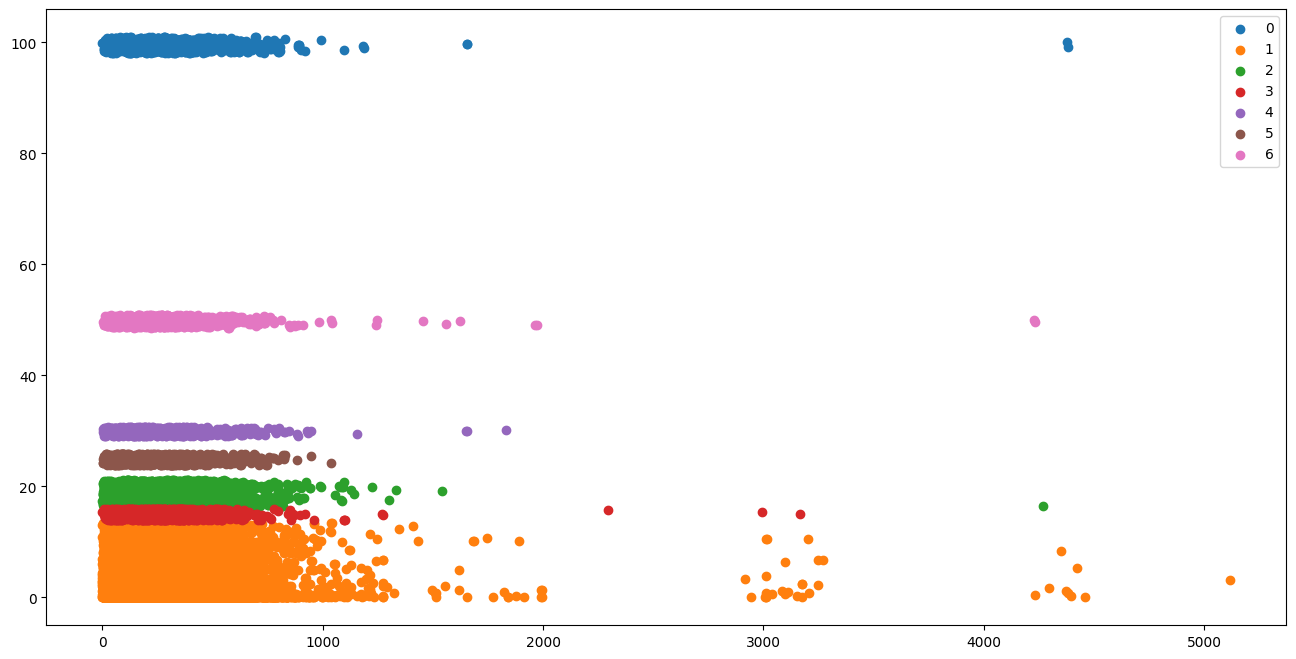

In [51]:
import matplotlib.pyplot as plt

#plotting the results
plt.figure(figsize=(16, 8))
plt.scatter(df_clusters[df_clusters.clusters == 0]['log_index'], X[clusters == 0], label = '0')
plt.scatter(df_clusters[df_clusters.clusters == 1]['log_index'], X[clusters == 1], label = '1')
plt.scatter(df_clusters[df_clusters.clusters == 2]['log_index'], X[clusters == 2], label = '2')
plt.scatter(df_clusters[df_clusters.clusters == 3]['log_index'], X[clusters == 3], label = '3')
plt.scatter(df_clusters[df_clusters.clusters == 4]['log_index'], X[clusters == 4], label = '4')
plt.scatter(df_clusters[df_clusters.clusters == 5]['log_index'], X[clusters == 5], label = '5')
plt.scatter(df_clusters[df_clusters.clusters == 6]['log_index'], X[clusters == 6], label = '6')
plt.legend()